In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as tri
import torch

In [3]:
# Load the Excel file
q_sheet = pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="q")  
head_sheet= pd.read_excel("Excel med PLAXIS.xlsx", sheet_name="Head")  

In [4]:
# Remove any leading/trailing spaces in column names
head_sheet.columns = head_sheet.columns.str.strip()

In [5]:
x = head_sheet["X [m]"].values
y = head_sheet["Y [m]"].values
head = head_sheet["Head [m]"].values

In [6]:
print(x.max(), x.min(), y.max(), y.min(), head.max(), head.min())

59.9794726725665 0.0204720845016275 -0.0131397078025069 -11.9868947373003 19.9999902190223 9.78176043437903e-06


In [7]:
# Define grid for interpolation
head.size

92208

In [8]:
print("Head min:", head.min(), "Head max:", head.max())

Head min: 9.78176043437903e-06 Head max: 19.9999902190223


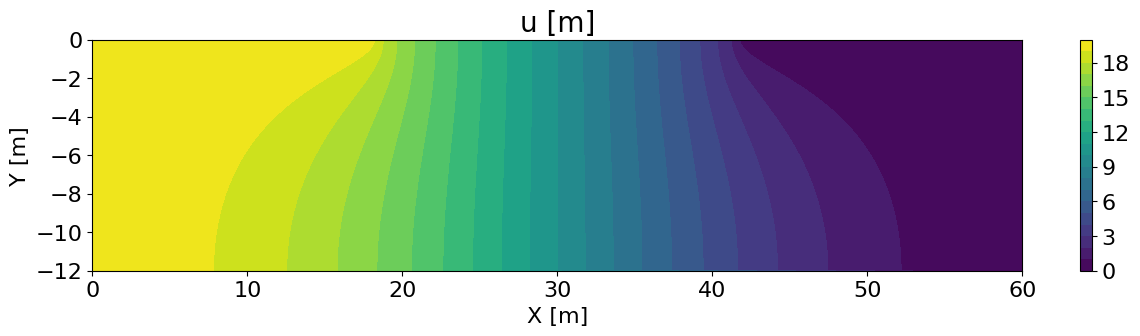

In [125]:
# Create a triangulation object
triang = tri.Triangulation(x, y)

print(triang)

# Set font sizes for plots
plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 16,  # Axis label font size
    'xtick.labelsize': 16,  # X-axis tick label size
    'ytick.labelsize': 16   # Y-axis tick label size
})

# Plot contour
plt.figure(figsize=(15, 3))
plt.tricontourf(triang, head, levels=20, cmap="viridis")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick label size
plt.yticks(np.arange(-12, 1, 2))
plt.xticks(np.arange(0, 61, 10))
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("u [m]")
plt.show()


In [148]:
def compare_nn_to_fem_with_contour(model, fem_x, fem_y, fem_head):

    # Convert FEM points to a torch tensor for NN evaluation
    fem_coords_transformed = torch.tensor(np.column_stack((fem_x / 60, (fem_y + 12) / 60)), dtype=torch.float32)

    # Get NN predictions at FEM points
    with torch.no_grad():
        nn_predictions = 20 * model(fem_coords_transformed).squeeze().numpy()

    # Calculate the difference
    absolute_difference = np.abs(nn_predictions - fem_head)
    difference = nn_predictions - fem_head

    # Compute error metrics
    mean_absolute_error = np.mean(absolute_difference)
    max_absolute_error = np.max(absolute_difference)
    rmse = np.sqrt(np.mean((nn_predictions - fem_head) ** 2))

    # Store results in a dictionary
    error_dict = {
        "Mean Absolute Error": mean_absolute_error,
        "Max Absolute Error": max_absolute_error,
        "Root Mean Squared Error (RMSE)": rmse
    }

    # Print errors for reference
    for key, value in error_dict.items():
        print(f"{key}: {value:.6f}")

    # Create triangulation
    triangulation = tri.Triangulation(fem_x, fem_y)

    # Set font sizes for plots
    plt.rcParams.update({
        'font.size': 16,  # General font size
        'axes.titlesize': 18,  # Title font size
        'axes.labelsize': 16,  # Axis label font size
        'xtick.labelsize': 14,  # X-axis tick label size
        'ytick.labelsize': 14   # Y-axis tick label size
    })

    # Plot absolute and relative error as contour plots
    fig, ax = plt.subplots(2, 1, figsize=(15, 7))

    # Plot neural network predictions as contour
    rel_contour = ax[0].tricontourf(triangulation, nn_predictions, levels=20, cmap="viridis")
    cbar = fig.colorbar(rel_contour, ax=ax[0])
    cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick label size
    ax[0].set_yticks(np.arange(-12, 1, 2))
    ax[0].set_xticks(np.arange(0, 61, 10))
    ax[0].set_title("PINN prediction of u [m]")
    ax[0].set_xlabel("X [m]")
    ax[0].set_ylabel("Y [m]")
    ax[0].grid(True)
    
    # Plot absolute error contour
    abs_contour = ax[1].tricontourf(
        triangulation, 
        difference, 
        levels=100, 
        cmap="coolwarm", 
        vmin=-np.max(np.abs(difference)),  # Minimum value for color scale (negative max)
        vmax=np.max(np.abs(difference))   # Maximum value for color scale (positive max)
    )
    cbar = fig.colorbar(abs_contour, ax=ax[1])
    cbar.ax.tick_params(labelsize=16)  # Increase colorbar tick label size
    ax[1].set_yticks(np.arange(-12, 1, 2))
    ax[1].set_xticks(np.arange(0, 61, 10))
    ax[1].set_title("PINN - FEM [m]")
    ax[1].set_xlabel("X [m]")
    ax[1].set_ylabel("Y [m]")
    ax[1].grid(True)


    plt.tight_layout()
    plt.show()

    return difference


In [238]:
import torch
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Now import the model class
from model_definition import pinn

# Create a new instance of the model
model = pinn(hidden_size=20, hidden_layers=8)  # Ensure the architecture matches the saved model

# Load the saved state dictionary into this new model instance
model.load_state_dict(torch.load("../#7.pth"))

# Set the model to evaluation mode
model.eval()  # This disables dropout, batch norm, etc., useful if you’re evaluating the model


C:\Users\jolu2\AppData\Local\Temp\ipykernel_20408\3977627501.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../#7.pth"))


pinn(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=20, bias=True)
    (17): Tanh()
    (18): Linear(in_features=20, out_features=1, bias=True)
  )
)

Mean Absolute Error: 0.046138
Max Absolute Error: 0.870337
Root Mean Squared Error (RMSE): 0.057736


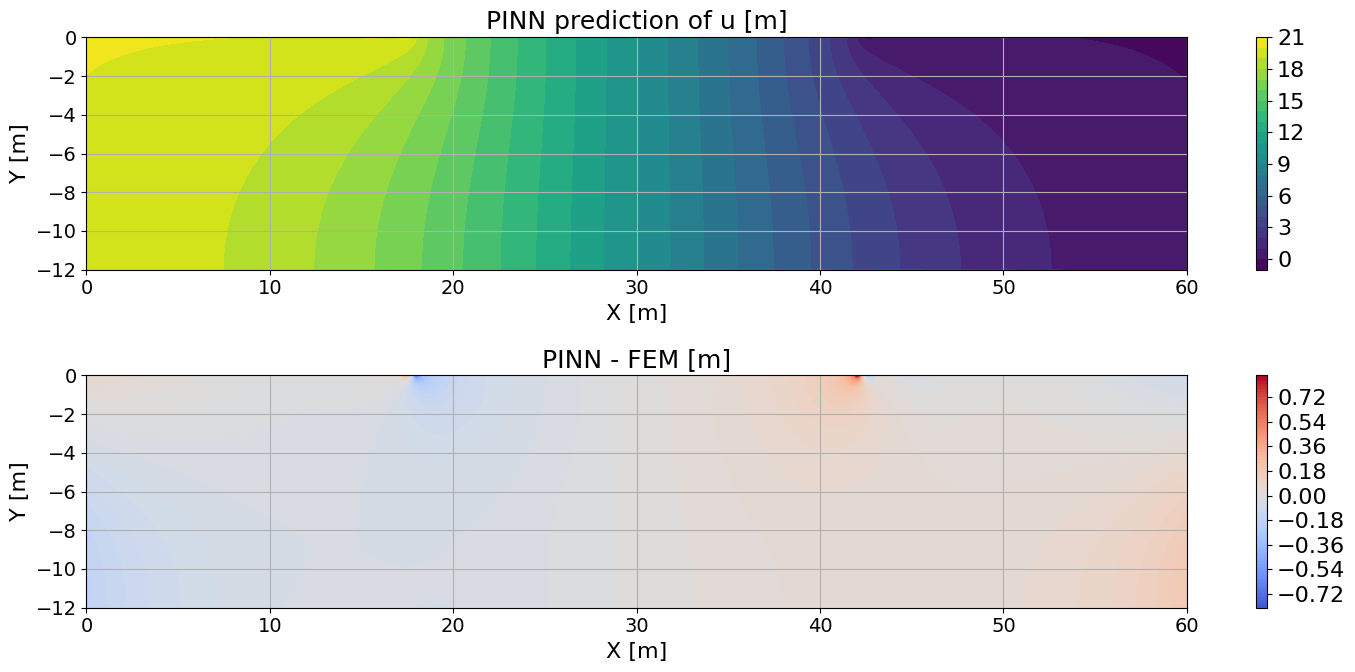

In [239]:
difference=compare_nn_to_fem_with_contour(model,x,y,head)

In [172]:
# Find the index of the maximum head value
max_index = np.argmax(difference)

# Get the coordinates of the maximum head value
max_x = x[max_index]
max_y = y[max_index]
difference_amx = difference[max_index]

print(f"Max head value: {difference_amx} at coordinates (X, Y): ({max_x}, {max_y})")

Max head value: 0.8208580757106341 at coordinates (X, Y): (42.0357734862918, -0.0206326182751236)


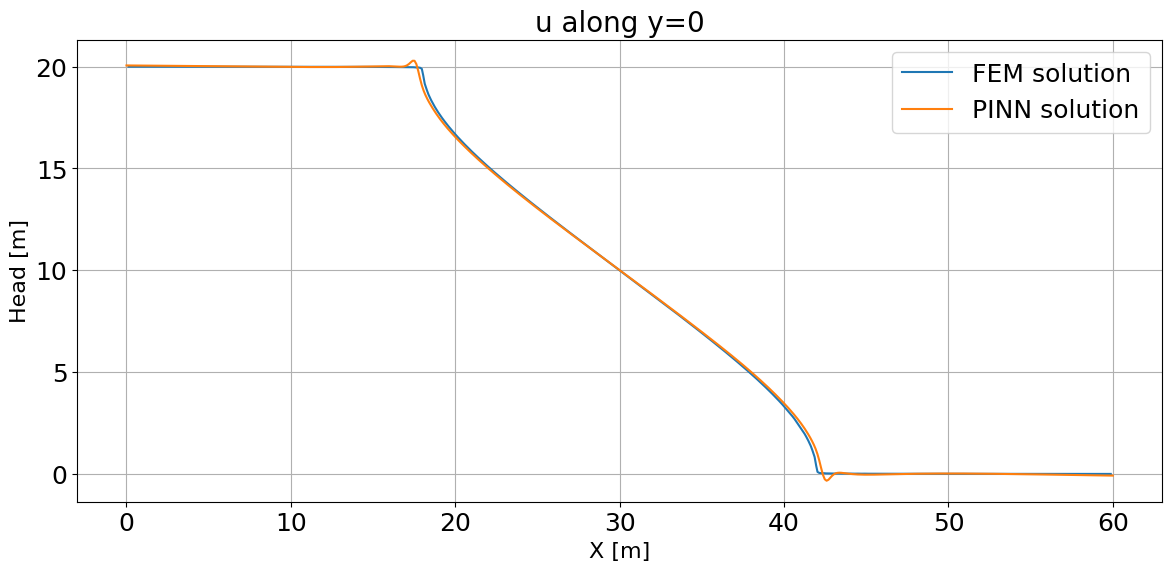

In [240]:
# Assuming x, y, and head are your data
triang = tri.Triangulation(x, y)

# Define a function to extract and interpolate values along y = 0.2
def extract_line(triang, head, y_value=0.2):
    # Find all points in the triangulation close to y = 0.2
    mask = np.isclose(triang.y, y_value, atol=0.225)
    
    # Extract x values and corresponding head values
    x_along_y = triang.x[mask]
    head_along_y = head[mask]
    
    # Sort by x for consistent plotting
    sorted_indices = np.argsort(x_along_y)
    return x_along_y[sorted_indices], head_along_y[sorted_indices]

# Extract the line at y = 0.2
x_line, head_line = extract_line(triang, head, y_value=0.2)

# Define the x values (0 to 1) and keep y fixed at 0.2
x_plot = np.linspace(0, 1, len(x_line))
y_plot = np.full_like(x_plot, 0.2)     # Keep y constant at 0.2
# Create a tensor of x_plot and y_plot
coords_plot = torch.tensor(np.c_[x_plot, y_plot], dtype=torch.float32)

# Evaluate the model
solution = 20*model(coords_plot).detach().numpy()

# Plot the line
plt.figure(figsize=(14, 6))
plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 18,  # Axis label font size
    'xtick.labelsize': 18,  # X-axis tick label size
    'ytick.labelsize': 18,  # Y-axis tick label size
})
plt.plot(x_line, head_line, label="FEM solution")
plt.plot(x_plot*60, solution, label="PINN solution")
plt.title("u along y=0", size=20)
plt.xlabel("X [m]",size=16)
plt.ylabel("Head [m]",size=16)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [207]:
# Generate boundary points for x = 30 and y in [-12, 0]
num_boundary_points = 10000
x_boundary = torch.full((num_boundary_points, 1), 0)  # (constant)
y_boundary = torch.linspace(-12, 0, num_boundary_points).unsqueeze(1)  # y in [-12, 0]

# Combine x and y to form boundary points
boundary_points = torch.cat([x_boundary, y_boundary], dim=1)

# Transform the boundary points according to your scaling
coords_transformed = torch.tensor(
    np.column_stack((x_boundary.numpy() / 60, (y_boundary.numpy() + 12) / 60)),
    dtype=torch.float32,
    requires_grad=True
)

# Predict the head at the scaled boundary points
head_line = 20*model(coords_transformed)

# Compute the gradient of the head w.r.t. transformed x and y
grad_h =1/60* torch.autograd.grad(head_line, coords_transformed, grad_outputs=torch.ones_like(head_line), create_graph=True)[0]
#I have to deivde by 60 since I scaled the coordinates and the gradients are computed based on the scaled coordinates

# Compute the flux using Darcy's law: q = -K * grad(h)
flux_x = -K * grad_h[:, 0]  # q_x (flux in x-direction)
flux_y = -K * grad_h[:, 1]  # q_y (flux in y-direction)

# Normal vector for the vertical boundary: n = (1, 0)
normal_flux = flux_x  # Since n = (1, 0), we only consider q_x

# Integrate the flux over the boundary (approximation using the trapezoidal rule)
#boundary_length = y_boundary[-1] - y_boundary[0]  # Length of the boundary
flow = torch.trapz(normal_flux, y_boundary.squeeze())  # Integrate w.r.t. y


print(f"Total flow out of the vertical boundary at x=30: {flow.item()}")

Total flow out of the vertical boundary at x=30: 0.9251794815063477


In [208]:
# Define the hydraulic conductivity
K = 1.0  # Replace with the appropriate value

# Generate boundary points for x in [42, 60] and y = 0
num_boundary_points = 10000
x_boundary = torch.linspace(0, 18, num_boundary_points).unsqueeze(1)  # x in [42, 60]
y_boundary = torch.full((num_boundary_points, 1),0)  # y = 0 (constant)

# Combine x and y to form boundary points
boundary_points = torch.cat([x_boundary, y_boundary], dim=1)

# Transform the boundary points according to your scaling
coords_transformed = torch.tensor(
    np.column_stack((x_boundary.numpy() / 60, (y_boundary.numpy()+12) / 60)), 
    dtype=torch.float32,
    requires_grad=True
)

# Predict the head at the scaled boundary points
head_line = 20* model(coords_transformed)

# Compute the gradient of the head w.r.t. transformed x and y
grad_h = 1/60*torch.autograd.grad(head_line, coords_transformed, grad_outputs=torch.ones_like(head_line), create_graph=True)[0]

# Compute the flux using Darcy's law: q = -K * grad(h)
flux_x = -K * grad_h[:, 0]  # q_x (flux in x-direction)
flux_y = -K * grad_h[:, 1]  # q_y (flux in y-direction)

# Normal vector for the bottom boundary (horizontal segment): n = (0, -1)
normal_flux = flux_y  # Since n = (0, -1), we only consider q_y

# Integrate the flux over the boundary (approximation using the trapezoidal rule)
# boundary_length = x_boundary[-1] - x_boundary[0]  # Length of the boundary
flow = torch.trapz(normal_flux, x_boundary.squeeze())  # Integrate w.r.t. x

print(f"Total flow out of under the dam: {flow.item()}")


Total flow out of under the dam: -5.488437175750732


In [209]:
# Generate boundary points for x = 30 and y in [-12, 0]
num_boundary_points = 10000
x_boundary = torch.full((num_boundary_points, 1), 30)  # (constant)
y_boundary = torch.linspace(-12, 0, num_boundary_points).unsqueeze(1)  # y in [-12, 0]

# Combine x and y to form boundary points
boundary_points = torch.cat([x_boundary, y_boundary], dim=1)

# Transform the boundary points according to your scaling
coords_transformed = torch.tensor(
    np.column_stack((x_boundary.numpy() / 60, (y_boundary.numpy() + 12) / 60)),
    dtype=torch.float32,
    requires_grad=True
)

# Predict the head at the scaled boundary points
head_line = 20*model(coords_transformed)

# Compute the gradient of the head w.r.t. transformed x and y
grad_h =1/60* torch.autograd.grad(head_line, coords_transformed, grad_outputs=torch.ones_like(head_line), create_graph=True)[0]
#I have to deivde by 60 since I scaled the coordinates and the gradients are computed based on the scaled coordinates

# Compute the flux using Darcy's law: q = -K * grad(h)
flux_x = -K * grad_h[:, 0]  # q_x (flux in x-direction)
flux_y = -K * grad_h[:, 1]  # q_y (flux in y-direction)

# Normal vector for the vertical boundary: n = (1, 0)
normal_flux = flux_x  # Since n = (1, 0), we only consider q_x

# Integrate the flux over the boundary (approximation using the trapezoidal rule)
#boundary_length = y_boundary[-1] - y_boundary[0]  # Length of the boundary
flow = torch.trapz(normal_flux, y_boundary.squeeze())  # Integrate w.r.t. y


print(f"Total flow out of the vertical boundary at x=30: {flow.item()}")

Total flow out of the vertical boundary at x=30: 6.939605712890625


In [210]:
# Generate boundary points for x = 30 and y in [-12, 0]
num_boundary_points = 10000
x_boundary = torch.full((num_boundary_points, 1), 60)  # (constant)
y_boundary = torch.linspace(-12, 0, num_boundary_points).unsqueeze(1)  # y in [-12, 0]

# Combine x and y to form boundary points
boundary_points = torch.cat([x_boundary, y_boundary], dim=1)

# Transform the boundary points according to your scaling
coords_transformed = torch.tensor(
    np.column_stack((x_boundary.numpy() / 60, (y_boundary.numpy() + 12) / 60)),
    dtype=torch.float32,
    requires_grad=True
)

# Predict the head at the scaled boundary points
head_line = 20*model(coords_transformed)

# Compute the gradient of the head w.r.t. transformed x and y
grad_h =1/60* torch.autograd.grad(head_line, coords_transformed, grad_outputs=torch.ones_like(head_line), create_graph=True)[0]
#I have to deivde by 60 since I scaled the coordinates and the gradients are computed based on the scaled coordinates

# Compute the flux using Darcy's law: q = -K * grad(h)
flux_x = -K * grad_h[:, 0]  # q_x (flux in x-direction)
flux_y = -K * grad_h[:, 1]  # q_y (flux in y-direction)

# Normal vector for the vertical boundary: n = (1, 0)
normal_flux = flux_x  # Since n = (1, 0), we only consider q_x

# Integrate the flux over the boundary (approximation using the trapezoidal rule)
#boundary_length = y_boundary[-1] - y_boundary[0]  # Length of the boundary
flow = torch.trapz(normal_flux, y_boundary.squeeze())  # Integrate w.r.t. y


print(f"Total flow out of the vertical boundary at x=30: {flow.item()}")

Total flow out of the vertical boundary at x=30: 0.4922330975532532


In [211]:
# Define the hydraulic conductivity
K = 1.0  # Replace with the appropriate value

# Generate boundary points for x in [42, 60] and y = 0
num_boundary_points = 10000
x_boundary = torch.linspace(42, 60, num_boundary_points).unsqueeze(1)  # x in [42, 60]
y_boundary = torch.full((num_boundary_points, 1),0)  # y = 0 (constant)

# Combine x and y to form boundary points
boundary_points = torch.cat([x_boundary, y_boundary], dim=1)

# Transform the boundary points according to your scaling
coords_transformed = torch.tensor(
    np.column_stack((x_boundary.numpy() / 60, (y_boundary.numpy()+12) / 60)), 
    dtype=torch.float32,
    requires_grad=True
)

# Predict the head at the scaled boundary points
head_line = 20* model(coords_transformed)

# Compute the gradient of the head w.r.t. transformed x and y
grad_h = 1/60*torch.autograd.grad(head_line, coords_transformed, grad_outputs=torch.ones_like(head_line), create_graph=True)[0]

# Compute the flux using Darcy's law: q = -K * grad(h)
flux_x = -K * grad_h[:, 0]  # q_x (flux in x-direction)
flux_y = -K * grad_h[:, 1]  # q_y (flux in y-direction)

# Normal vector for the bottom boundary (horizontal segment): n = (0, -1)
normal_flux = flux_y  # Since n = (0, -1), we only consider q_y

# Integrate the flux over the boundary (approximation using the trapezoidal rule)
# boundary_length = x_boundary[-1] - x_boundary[0]  # Length of the boundary
flow = torch.trapz(normal_flux, x_boundary.squeeze())  # Integrate w.r.t. x

print(f"Total flow out of under the dam: {flow.item()}")


Total flow out of under the dam: 4.996773719787598
